Импорт необходимых библиотек и настройки по умолчанию

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)
plt.style.use('ggplot')
np.set_printoptions(precision=3, suppress=True)

# import warnings
# warnings.filterwarnings('ignore')

In [2]:
def plot_scatter(x, y, title, x_label, ylabel, c="b"):
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(ylabel)
    plt.scatter(x, y, c=c)
    plt.show()

def plot_hist(x, title="", xlabel=""):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Количество")
    plt.hist(x, bins = 30)
    plt.show()

Подготовка и обзор датасета

In [3]:
# X_bp.xlsx данные о свзяующем (матрице?) и выходные
bp_df = pd.read_excel('ds\X_bp.xlsx')
bp_df.rename(columns={'Unnamed: 0':'indx'}, inplace=True)
print("\nразмерность bp:", bp_df.shape)

# X_nup данные о нашивке (наполнителе?) (геометрии армирования?)
nup_df = pd.read_excel('ds\X_nup.xlsx')
nup_df.rename(columns={'Unnamed: 0':'indx'}, inplace=True)
print("\nразмерность nup:", nup_df.shape)

#проверка индексов на дубли
duplicate = bp_df[bp_df.duplicated('indx')]
print("\nколичество дублей в индексе bp:", duplicate.shape[0])
duplicate = nup_df[nup_df.duplicated('indx')]
print("\nколичество дублей в индексе nup:", duplicate.shape[0])

# в поле indx дублей нет. можно объединять, в противнм случает
# перед объединением необходимо обработать дубли, т.к. алгоритмам ML ненужные данные не нужны.
# raw_df для анализа, внутренне объединение bp и nup по indx
raw_df = pd.merge(bp_df, nup_df, on='indx', how='inner')

#проверка записей raw_df на дубли
duplicate = raw_df[raw_df.duplicated()]
print("\nколичество дублей записей в raw_df:", duplicate.shape[0])

# indx сделал свое дело
raw_df.drop(['indx'], axis=1, inplace = True)

print("\nразмерность raw_df:", raw_df.shape)

raw_df.head()


размерность bp: (1023, 11)

размерность nup: (1040, 4)

количество дублей в индексе bp: 0

количество дублей в индексе nup: 0

количество дублей записей в raw_df: 0

размерность raw_df: (1023, 13)


Соотношение матрица-наполнитель  Плотность, кг/м3  модуль упругости, ГПа  \
0                         1.857143            2030.0             738.736842   
1                         1.857143            2030.0             738.736842   
2                         1.857143            2030.0             738.736842   
3                         1.857143            2030.0             738.736842   
4                         2.771331            2030.0             753.000000   

   Количество отвердителя, м.%  Содержание эпоксидных групп,%_2  \
0                        30.00                        22.267857   
1                        50.00                        23.750000   
2                        49.90                        33.000000   
3                       129.00                        21.250000   
4                       111.86                        22.267857   

   Температура вспышки, С_2  Поверхностная плотность, г/м2  \
0                100.000000                          210.0   
1                284.615385                          210.0   
2                284.615385                          210.0   
3                300.000000                          210.0   
4                284.615385                          210.0   

   Модуль упругости при растяжении, ГПа  Прочность при растяжении, МПа  \
0                                  70.0                         3000.0   
1                                  70.0                         3000.0   
2                                  70.0                         3000.0   
3                                  70.0                         3000.0   
4                                  70.0                         3000.0   

   Потребление смолы, г/м2  Угол нашивки, град  Шаг нашивки  Плотность нашивки  
0                    220.0                 0.0          4.0               57.0  
1                    220.0                 0.0          4.0               60.0  
2                    220.0                 0.0          4.0               70.0  
3                    220.0                 0.0          5.0               47.0  
4                    220.0                 0.0          5.0               57.0

# Разведочный анализ данных

In [4]:
df = raw_df.copy()
# Знакомимся с датасетом
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1023 entries, 0 to 1022
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Соотношение матрица-наполнитель       1023 non-null   float64
 1   Плотность, кг/м3                      1023 non-null   float64
 2   модуль упругости, ГПа                 1023 non-null   float64
 3   Количество отвердителя, м.%           1023 non-null   float64
 4   Содержание эпоксидных групп,%_2       1023 non-null   float64
 5   Температура вспышки, С_2              1023 non-null   float64
 6   Поверхностная плотность, г/м2         1023 non-null   float64
 7   Модуль упругости при растяжении, ГПа  1023 non-null   float64
 8   Прочность при растяжении, МПа         1023 non-null   float64
 9   Потребление смолы, г/м2               1023 non-null   float64
 10  Угол нашивки, град                    1023 non-null   float64
 11  Шаг нашивки      

In [5]:
# Проверяем на NaN. Большинство моделей не предполагают пропусков в данных.
# Использование isna() считается предпочтительнее isnull(), хотя оба метода дают одинаковый результат
df.isna().sum()


Соотношение матрица-наполнитель         0
Плотность, кг/м3                        0
модуль упругости, ГПа                   0
Количество отвердителя, м.%             0
Содержание эпоксидных групп,%_2         0
Температура вспышки, С_2                0
Поверхностная плотность, г/м2           0
Модуль упругости при растяжении, ГПа    0
Прочность при растяжении, МПа           0
Потребление смолы, г/м2                 0
Угол нашивки, град                      0
Шаг нашивки                             0
Плотность нашивки                       0
dtype: int64

Text(0.5, 1.0, 'Тепловая карта неуказанных значений признаков')

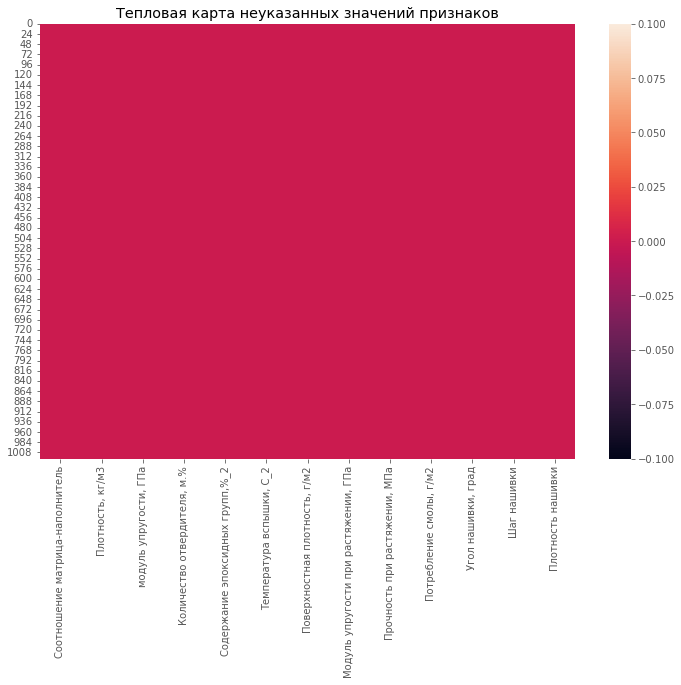

In [6]:
# Можно визуализировать пропуски, но ничего не увидим, так как пропусков нет.
sns.heatmap(df.isna(), cbar = True).set_title("Тепловая карта неуказанных значений признаков")

In [7]:
# посмотри количество неуникальных значений для лучшего понимания значений признаков датасета
df.nunique()

Соотношение матрица-наполнитель         1014
Плотность, кг/м3                        1013
модуль упругости, ГПа                   1020
Количество отвердителя, м.%             1005
Содержание эпоксидных групп,%_2         1004
Температура вспышки, С_2                1003
Поверхностная плотность, г/м2           1004
Модуль упругости при растяжении, ГПа    1004
Прочность при растяжении, МПа           1004
Потребление смолы, г/м2                 1003
Угол нашивки, град                         2
Шаг нашивки                              989
Плотность нашивки                        988
dtype: int64

In [8]:
# 'Угол нашивки, град' принимает только два значения
# возможно будет уместно привести занчения к 0 или 1, но всего два числовых значения. не понятно пока.
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# df['Угол нашивки, град'] = le.fit_transform(df['Угол нашивки, град'])
df['Угол нашивки, град'].unique()

array([ 0., 90.])

In [9]:
# описательная статистика
df.describe().round(3).T

count      mean      std       min  \
Соотношение матрица-наполнитель       1023.0     2.930    0.913     0.389   
Плотность, кг/м3                      1023.0  1975.735   73.729  1731.765   
модуль упругости, ГПа                 1023.0   739.923  330.232     2.437   
Количество отвердителя, м.%           1023.0   110.571   28.296    17.740   
Содержание эпоксидных групп,%_2       1023.0    22.244    2.406    14.255   
Температура вспышки, С_2              1023.0   285.882   40.943   100.000   
Поверхностная плотность, г/м2         1023.0   482.732  281.315     0.604   
Модуль упругости при растяжении, ГПа  1023.0    73.329    3.119    64.054   
Прочность при растяжении, МПа         1023.0  2466.923  485.628  1036.857   
Потребление смолы, г/м2               1023.0   218.423   59.736    33.803   
Угол нашивки, град                    1023.0    44.252   45.016     0.000   
Шаг нашивки                           1023.0     6.899    2.563     0.000   
Плотность нашивки                     1023.0    57.154   12.351     0.000   

                                           25%       50%       75%       max  
Соотношение матрица-наполнитель          2.318     2.907     3.553     5.592  
Плотность, кг/м3                      1924.155  1977.622  2021.374  2207.773  
модуль упругости, ГПа                  500.047   739.664   961.813  1911.536  
Количество отвердителя, м.%             92.443   110.565   129.730   198.953  
Содержание эпоксидных групп,%_2         20.608    22.231    23.962    33.000  
Температура вспышки, С_2               259.067   285.897   313.002   413.273  
Поверхностная плотность, г/м2          266.817   451.864   693.225  1399.542  
Модуль упругости при растяжении, ГПа    71.245    73.269    75.357    82.682  
Прочность при растяжении, МПа         2135.850  2459.525  2767.193  3848.437  
Потребление смолы, г/м2                179.628   219.199   257.482   414.591  
Угол нашивки, град                       0.000     0.000    90.000    90.000  
Шаг нашивки                              5.080     6.916     8.586    14.441  
Плотность нашивки                       49.799    57.342    64.945   103.989

## Гистограммы распределения значений каждого признака

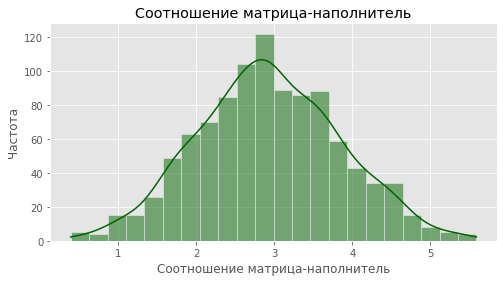

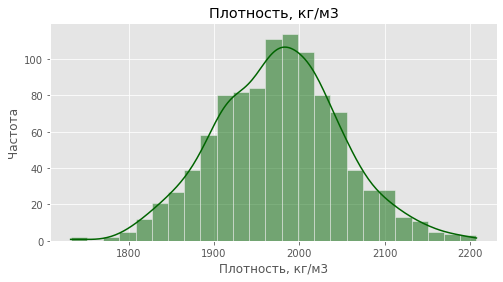

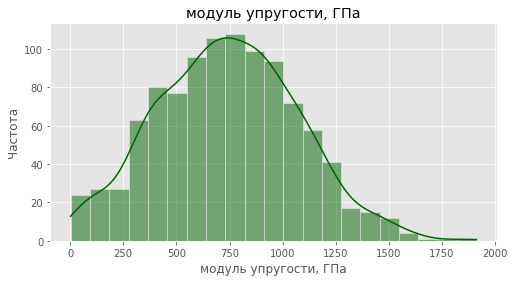

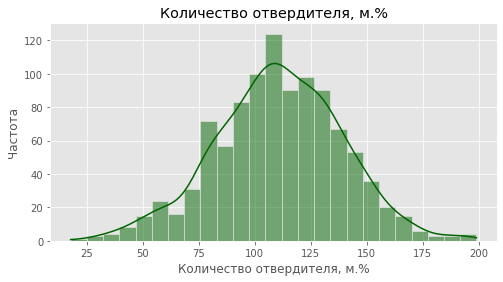

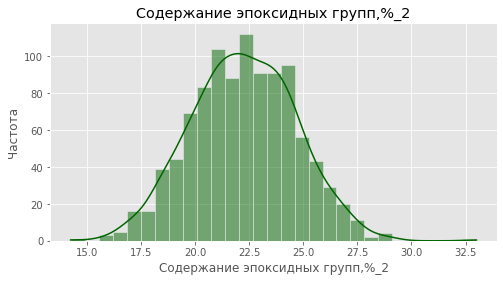

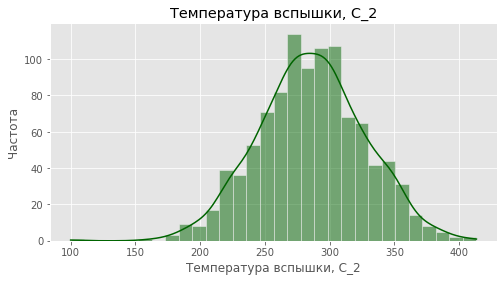

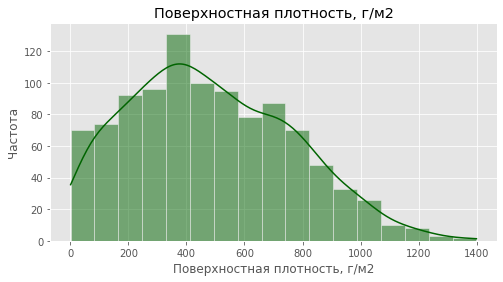

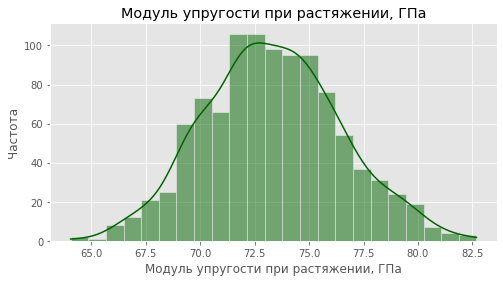

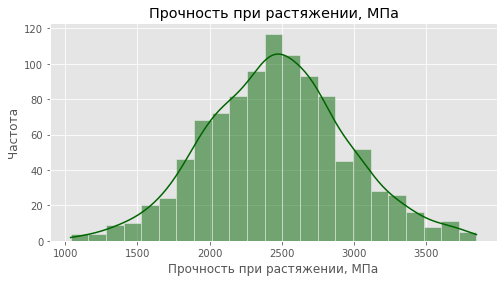

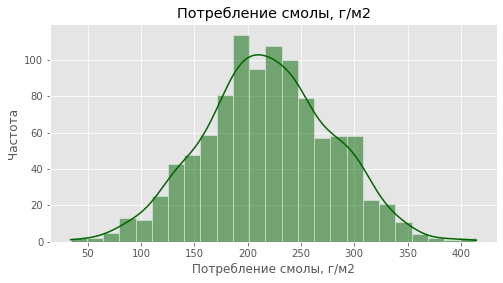

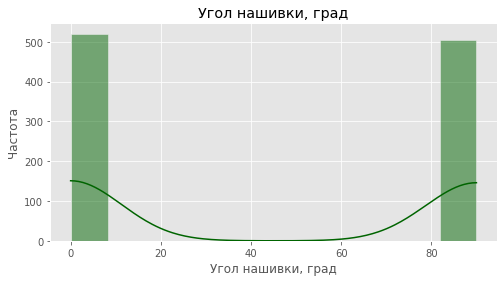

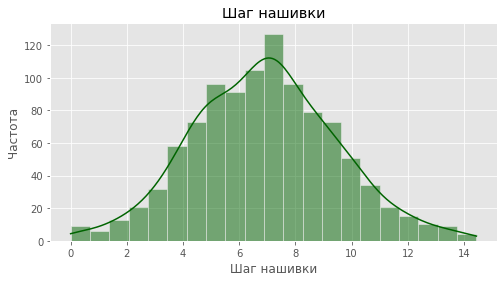

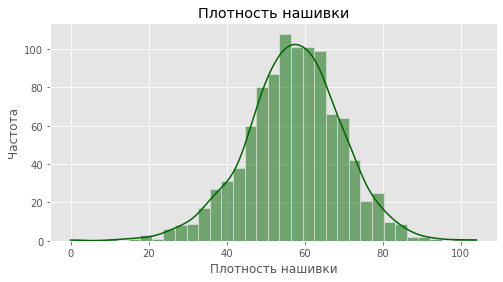

In [10]:
for col in df.columns:
    plt.figure(figsize=(8,4))
    plt.title(col)
    plt.ylabel('Частота')
    sns.histplot(data = df[col], color='darkgreen', kde=True)
    plt.show()

### Формальная проверка нормальности распределения значений признаков

In [11]:
# метод normaltest 
# https://towardsdatascience.com/methods-for-normality-test-with-application-in-python-bb91b49ed0f5
norm_distr = []
not_norm_distr = []

for col in df.columns:
    alpha = 0.05
    stat, p = scipy.stats.normaltest(df[col]) # Критерий согласия Пирсона
    print('%-38s p-val=%.3f' % (col, p))
    if p > alpha:
        norm_distr.append(col)
    else:
        not_norm_distr.append(col)
        
print('\nВероятно, что нормальное распределение значений имеют признаки:\n')
for i in norm_distr:
    print(i)
    
print('\nВозможно, что распределение значений не соответсвует нормальному в признаках:\n')
for i in not_norm_distr:
    print(i)

Соотношение матрица-наполнитель        p-val=0.214
Плотность, кг/м3                       p-val=0.662
модуль упругости, ГПа                  p-val=0.103
Количество отвердителя, м.%            p-val=0.329
Содержание эпоксидных групп,%_2        p-val=0.730
Температура вспышки, С_2               p-val=0.365
Поверхностная плотность, г/м2          p-val=0.000
Модуль упругости при растяжении, ГПа   p-val=0.139
Прочность при растяжении, МПа          p-val=0.574
Потребление смолы, г/м2                p-val=0.724
Угол нашивки, град                     p-val=0.000
Шаг нашивки                            p-val=0.410
Плотность нашивки                      p-val=0.000

Вероятно, что нормальное распределение значений имеют признаки:

Соотношение матрица-наполнитель
Плотность, кг/м3
модуль упругости, ГПа
Количество отвердителя, м.%
Содержание эпоксидных групп,%_2
Температура вспышки, С_2
Модуль упругости при растяжении, ГПа
Прочность при растяжении, МПа
Потребление смолы, г/м2
Шаг нашивки

Возможно, ч

### Корреляция

#### Попарные графики рассеивания точек всех переменных

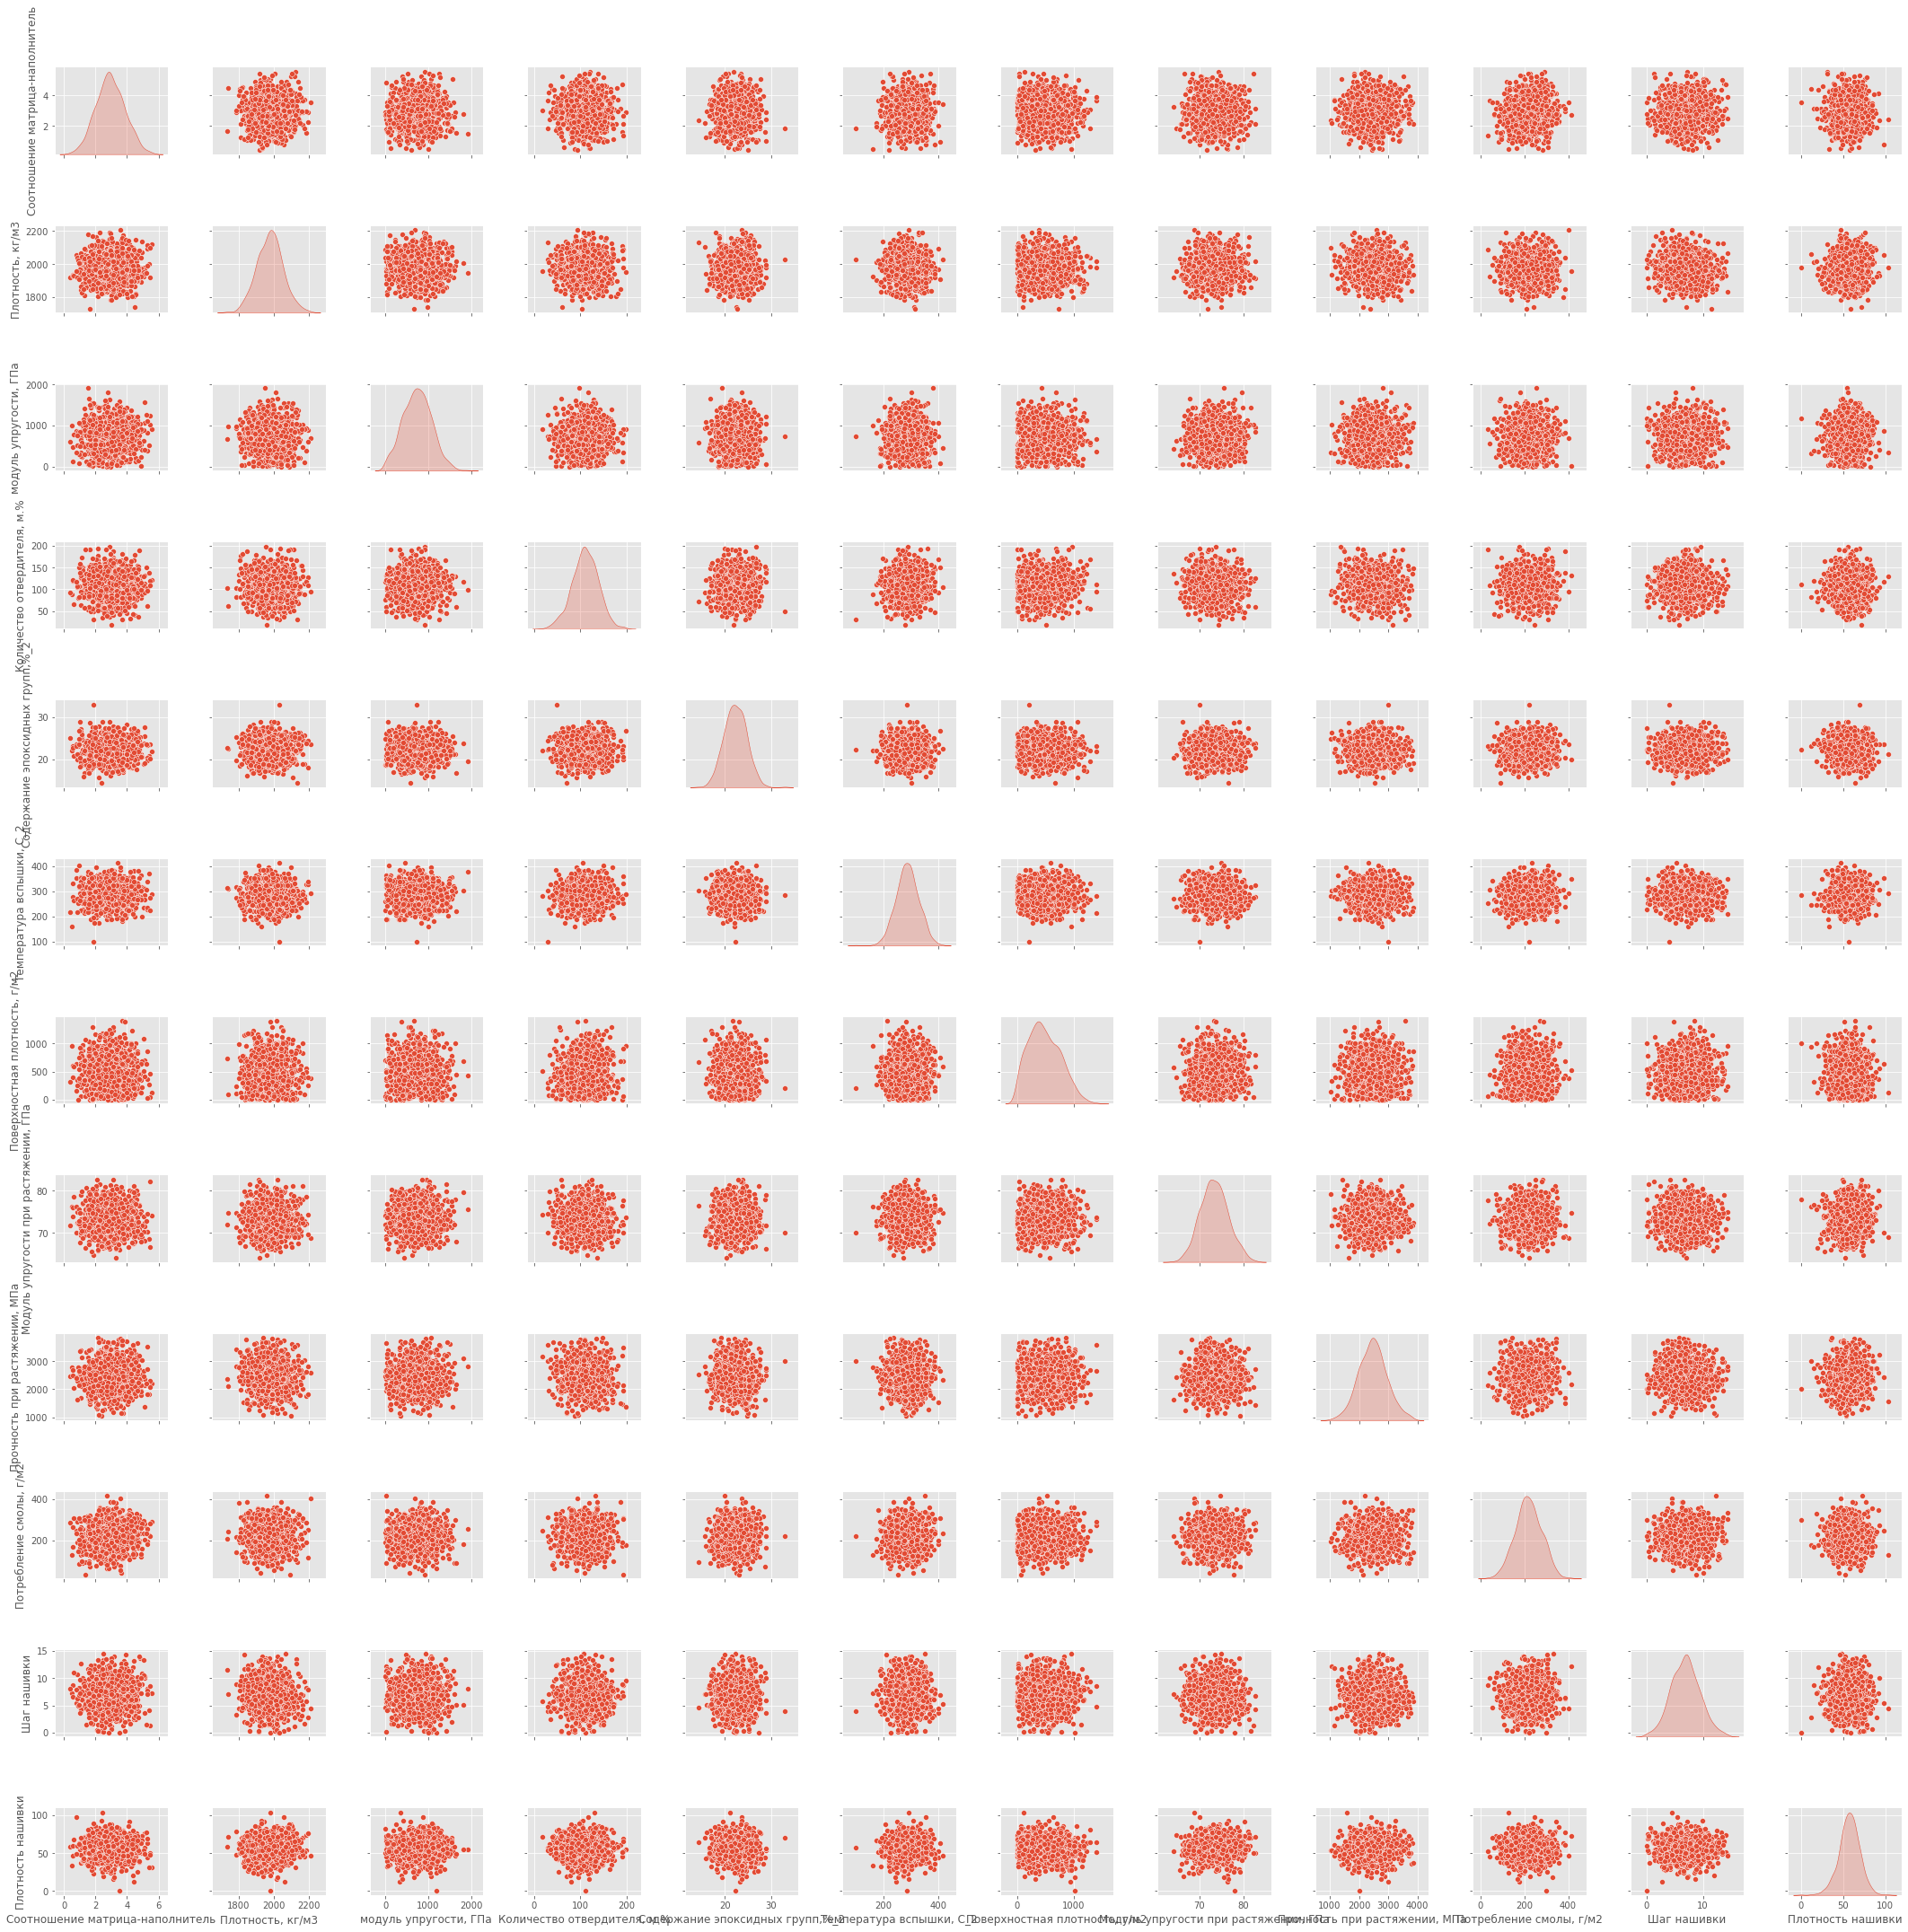

In [12]:
pp_df = df.copy()
# 'Угол нашивки, град' удалим, этот признак кажется не информативным
pp_df.drop(['Угол нашивки, град'], axis=1, inplace=True)
sns.pairplot(pp_df, diag_kind='kde')

#### Попарные графики рассеивания возможно наиболее интересных факторов

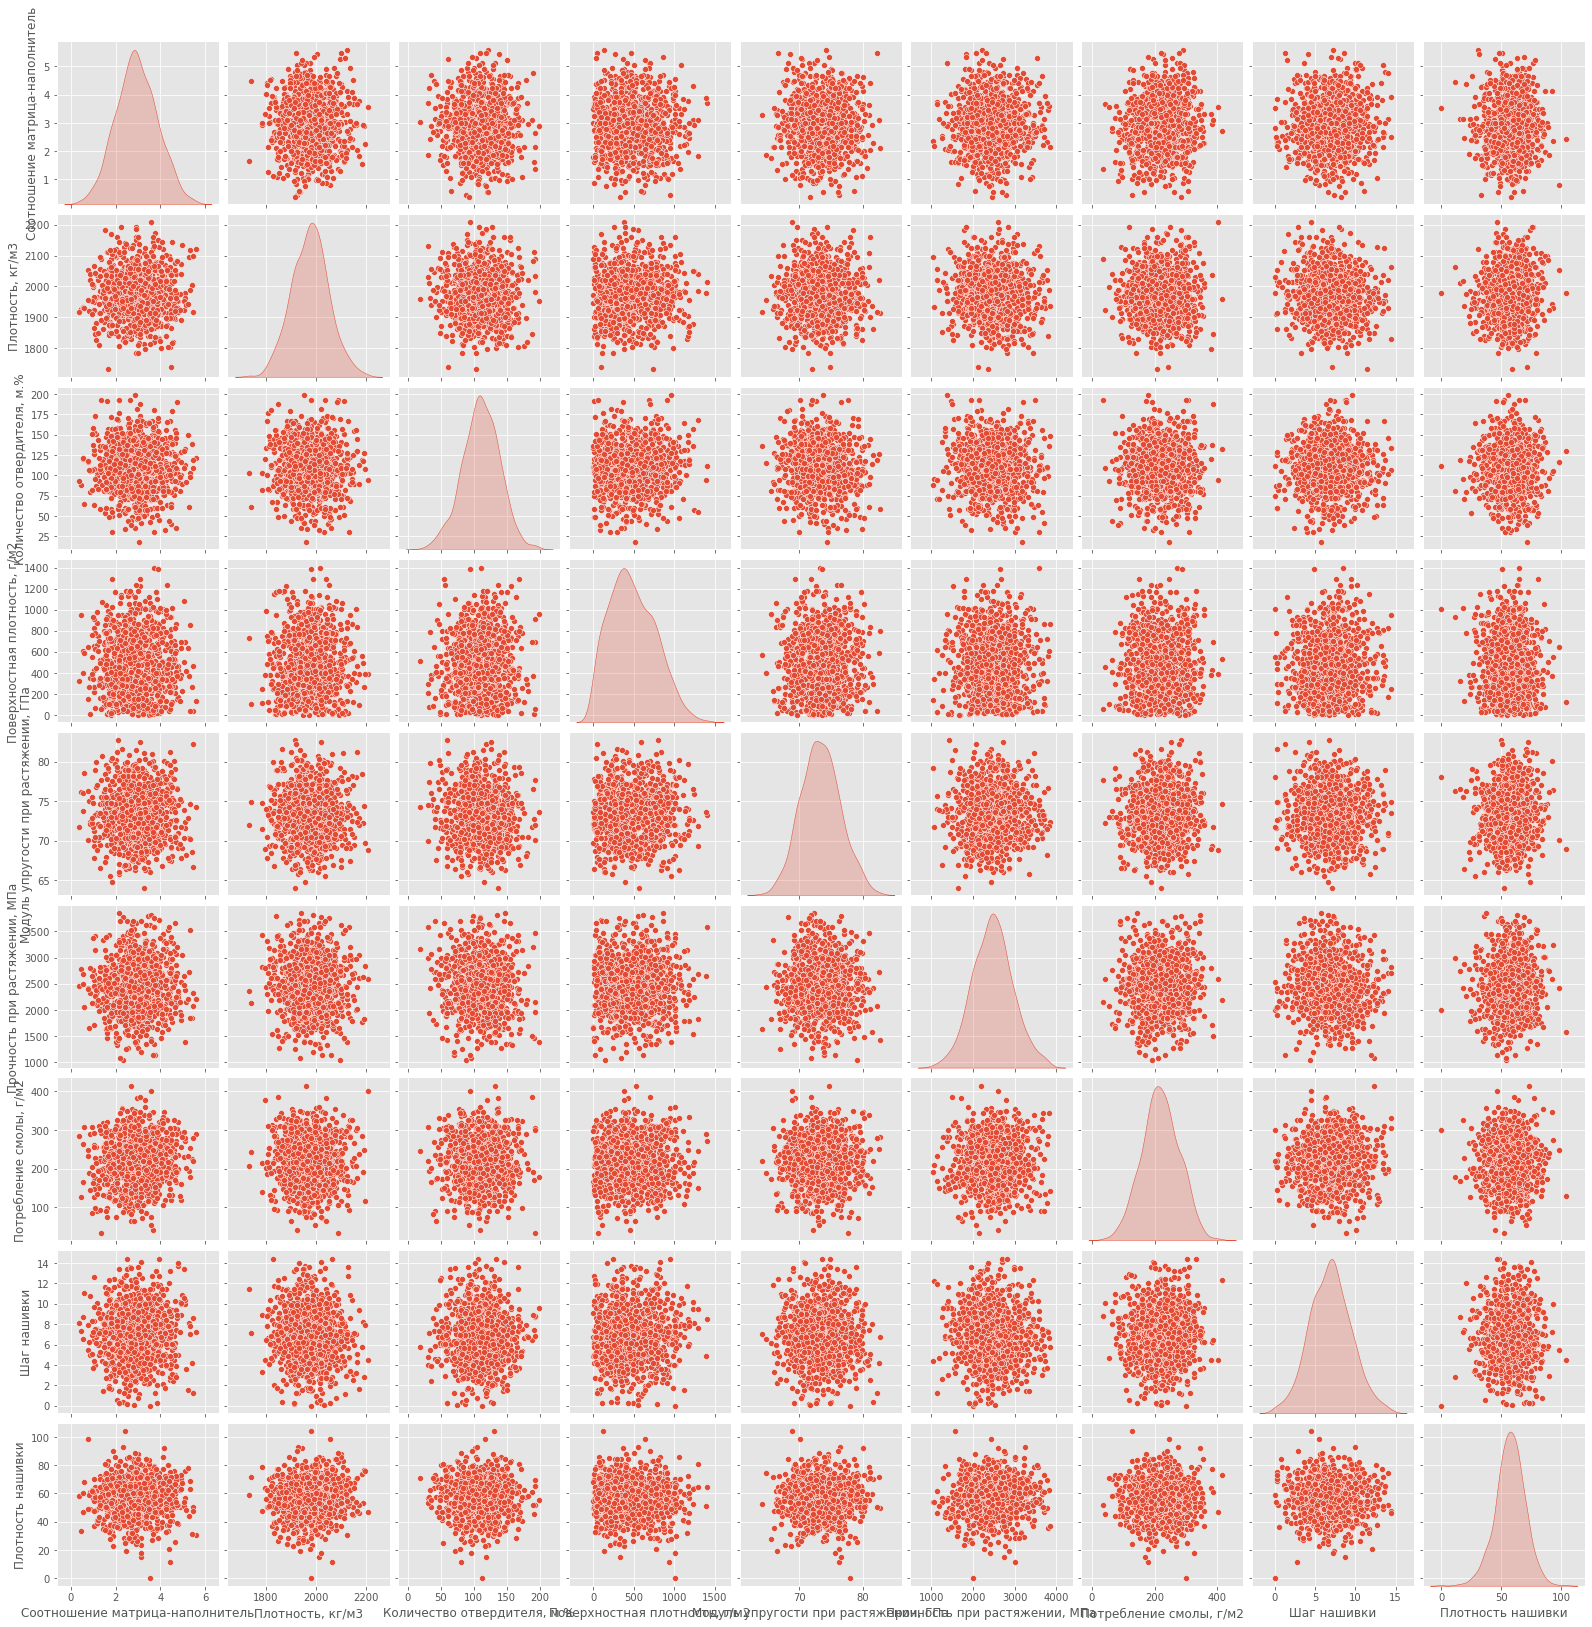

In [61]:
pp_df = df.copy()
pp_df.drop(['Угол нашивки, град'], axis=1, inplace=True)
sns.pairplot(pp_df[
    [
     'Соотношение матрица-наполнитель',
     'Плотность, кг/м3',
#     'модуль упругости, ГПа',
     'Количество отвердителя, м.%',
#     'Содержание эпоксидных групп,%_2',
#     'Температура вспышки, С_2',
     'Поверхностная плотность, г/м2',
     'Модуль упругости при растяжении, ГПа',
     'Прочность при растяжении, МПа',
     'Потребление смолы, г/м2',
     'Шаг нашивки',
     'Плотность нашивки']
    ], diag_kind='kde')
#sns.pairplot(pp_df)

### Попарные графики рассеивания говорят об отсутствии зависимостей меду значениями признаков. Заметны возможные выбросы. 

***в поисках корреляции***

###### ***Количество отвердителя, м.% Написано, что в %, если по отношению к Потребление смолы, г/м2, то***
###### ***Смола с отвердителем = Потребление смолы, г/м2 + (Потребление смолы, г/м2 * Количество отвердителя, м.% / 100)***
###### ***Допустим, что 'Шаг нашивки' и 'Плотность нашивки' характеризуют геометрию армирования, тогда***
###### ***Геометрия Армирования = 'Шаг нашивки' * 'Плотность нашивки'***

In [14]:
alf_df = pp_df.copy()
alf_df['смлОтв'] = alf_df['Потребление смолы, г/м2'] + (alf_df['Потребление смолы, г/м2'] * alf_df['Количество отвердителя, м.%'] / 100)
alf_df['геомАрм'] = alf_df['Шаг нашивки'] * alf_df['Плотность нашивки']

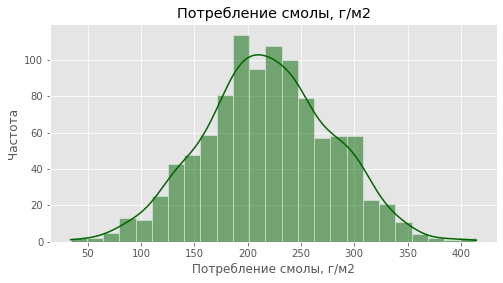

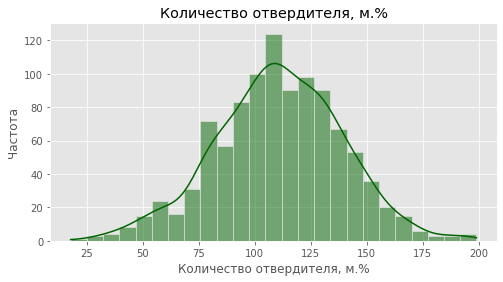

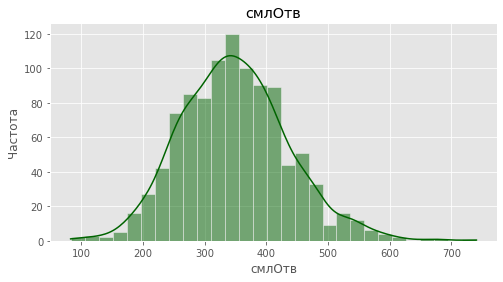

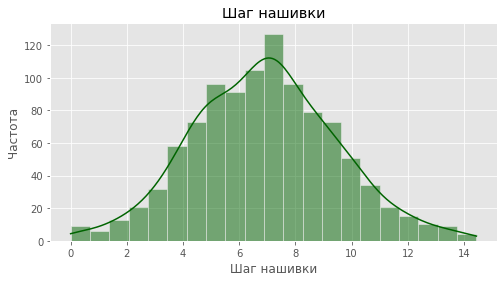

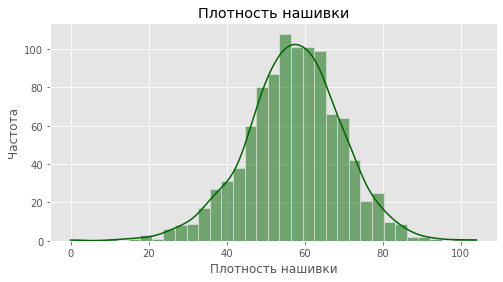

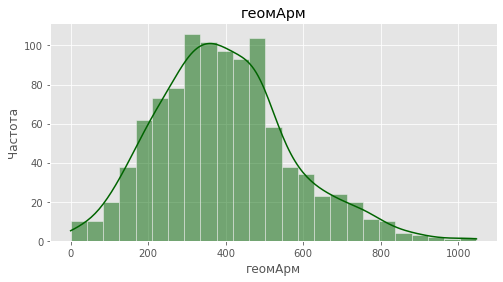

In [15]:
colToViewHistPlot = ['Потребление смолы, г/м2','Количество отвердителя, м.%','смлОтв','Шаг нашивки','Плотность нашивки','геомАрм']
for col in colToViewHistPlot:
    plt.figure(figsize=(8,4))
    plt.title(col)
    plt.ylabel('Частота')
    sns.histplot(data = alf_df[col], color='darkgreen', kde=True)
    plt.show()

In [16]:
alf_df.drop([
             'Шаг нашивки', 
             'Плотность нашивки',
             'Количество отвердителя, м.%',
             'Потребление смолы, г/м2'
            ], axis=1, inplace = True)

##### Посмотрим, что получилось

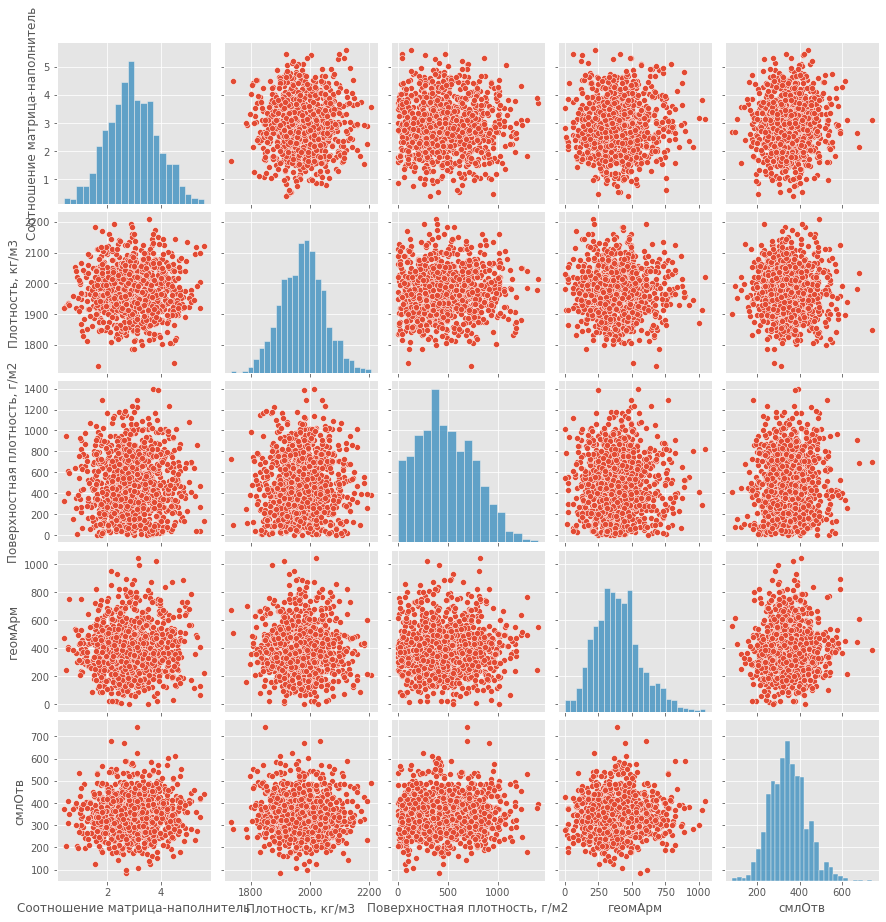

In [17]:
sns.pairplot(alf_df[
    [
     'Соотношение матрица-наполнитель',
     'Плотность, кг/м3',        
     'Поверхностная плотность, г/м2',   
     'геомАрм',
     'смлОтв'
    ]
    ], diag_kind='hist')

In [18]:
alf_df.head()

Соотношение матрица-наполнитель  Плотность, кг/м3  модуль упругости, ГПа  \
0                         1.857143            2030.0             738.736842   
1                         1.857143            2030.0             738.736842   
2                         1.857143            2030.0             738.736842   
3                         1.857143            2030.0             738.736842   
4                         2.771331            2030.0             753.000000   

   Содержание эпоксидных групп,%_2  Температура вспышки, С_2  \
0                        22.267857                100.000000   
1                        23.750000                284.615385   
2                        33.000000                284.615385   
3                        21.250000                300.000000   
4                        22.267857                284.615385   

   Поверхностная плотность, г/м2  Модуль упругости при растяжении, ГПа  \
0                          210.0                                  70.0   
1                          210.0                                  70.0   
2                          210.0                                  70.0   
3                          210.0                                  70.0   
4                          210.0                                  70.0   

   Прочность при растяжении, МПа      смлОтв  геомАрм  
0                         3000.0  229.000000    228.0  
1                         3000.0  245.000000    240.0  
2                         3000.0  244.900100    280.0  
3                         3000.0  386.410000    235.0  
4                         3000.0  345.126596    285.0

#### Чуда корреляции не произошло. Необходимо эксперное знание в предметной области

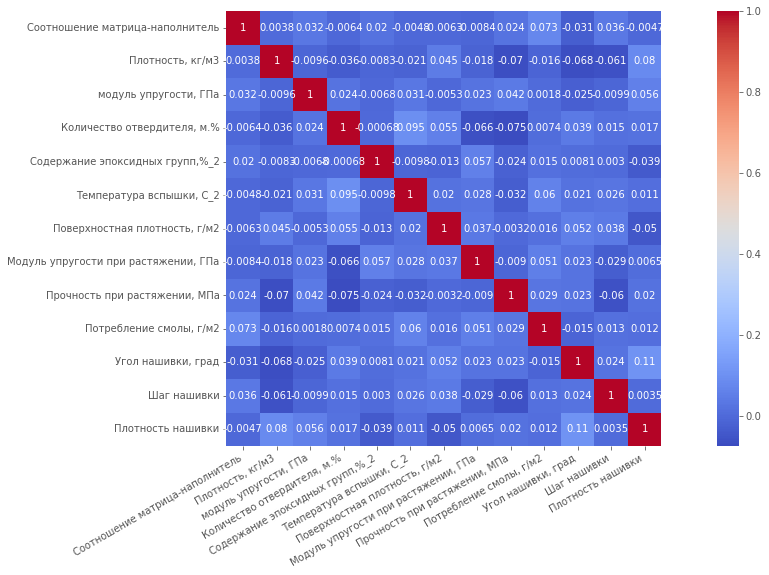

In [19]:
# полная тепловая карта датасета
plt.figure(figsize = (20, 8))
sns.heatmap(df.corr(), annot=True, square=True, cmap='coolwarm')
plt.xticks(rotation=30, ha='right')
plt.show()

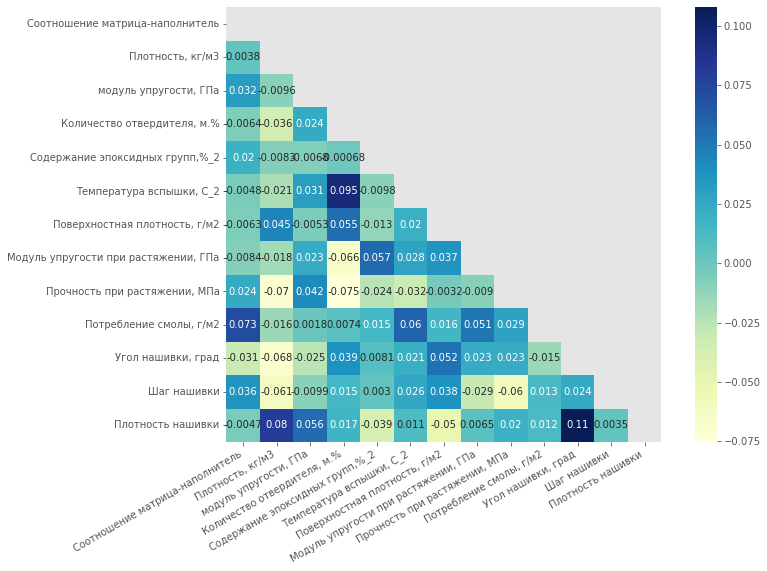

In [20]:
# triu возвращает часть матрицы, включая главную диагональ и все элементы над или под ней
# удобно визуализировать максимальное значение коээфициента корреляции, но только после просмотра полной тепловой карты
# так как можно обнануться яркими пятнами на половине матрицы
sns.heatmap(df.corr(), mask=np.triu(df.corr()), annot=True, square=True, cmap='YlGnBu')
plt.xticks(rotation=30, ha='right')
plt.show()

***Коэффициент корреляции стремится к 0***

### Нормализация и стандартизация

Посмотрим Box Plot всех признаков до удаления и нормализации

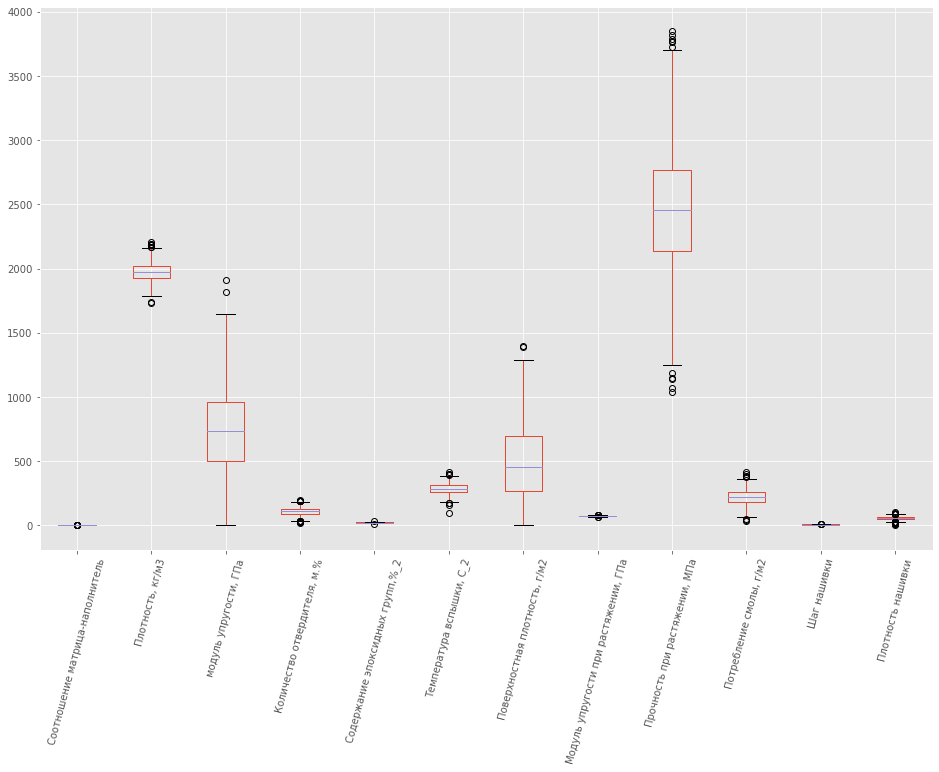

In [21]:
boxplot = pp_df.boxplot(rot=75, figsize=(16,10))

***нормализация. основной недостаток нормализации в том, что значения признака нормализуются в диапазоне от 0 до 1, а при наличии выбросов значения признака в результате нормализации оказываются в еще меньшем диапазоне.***

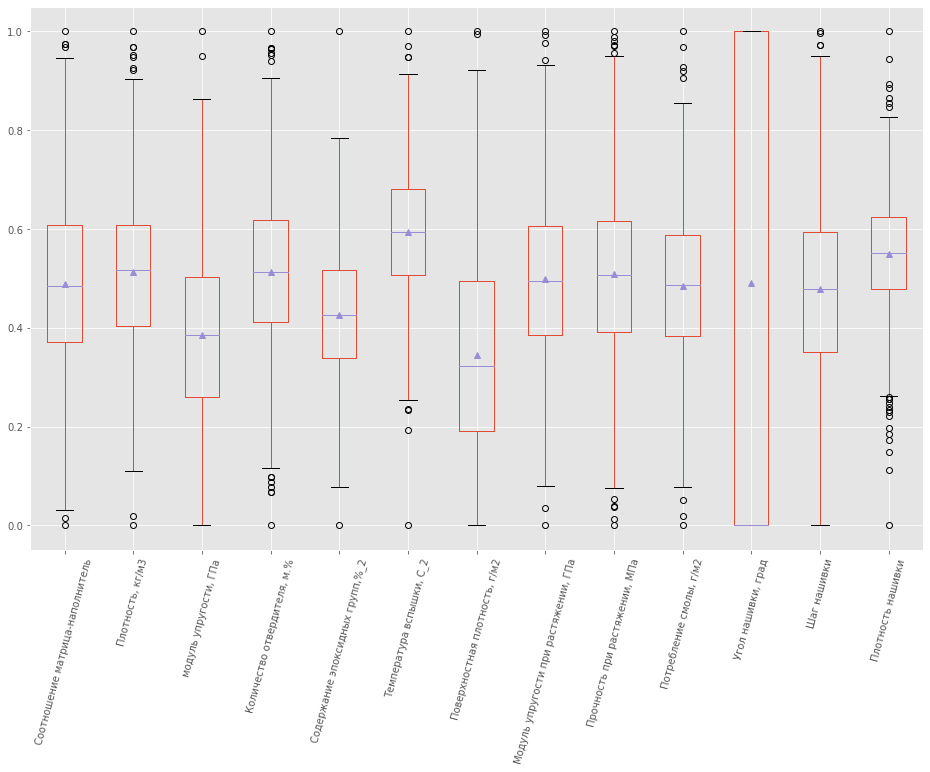

In [22]:
from sklearn.preprocessing import MinMaxScaler
# посмотрим разные способы трансформации и оставим, который больше понарвится
# df
tf_df = df.copy()
min_max_scaler = MinMaxScaler().fit(tf_df)
tf_df = pd.DataFrame(min_max_scaler.transform(tf_df), columns=list(tf_df.columns))
boxplot = tf_df.boxplot(rot=75, figsize=(16,10), showmeans=True)

***Стандартизация. Профит стандартизации в том, что выбросы в меньшей степени влияют на преобразование значений.***

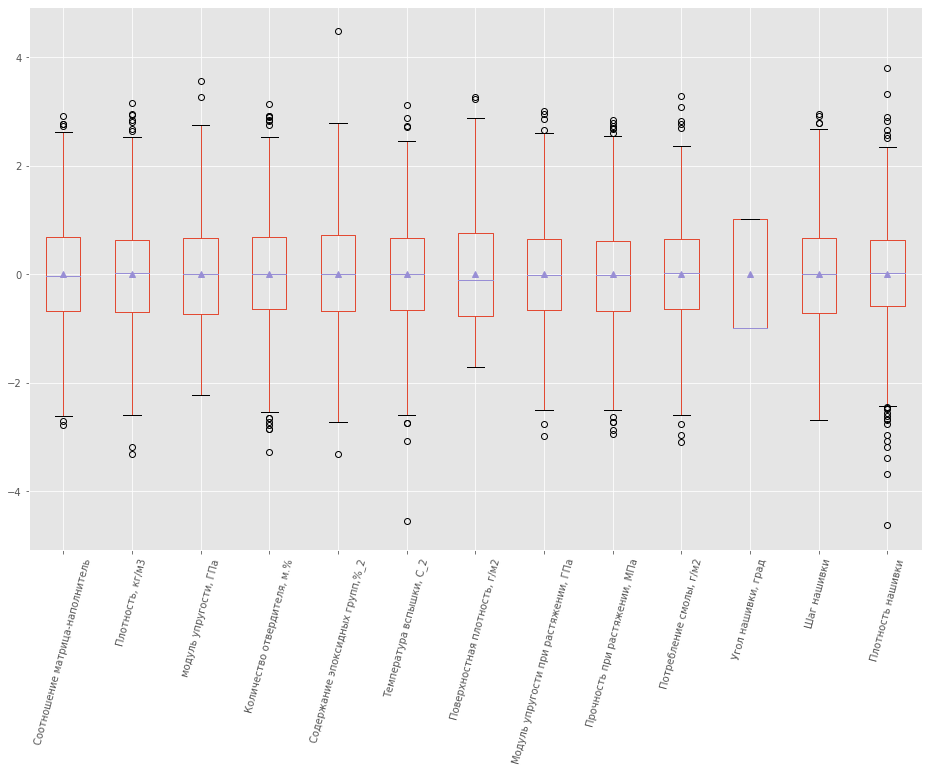

In [23]:
from sklearn.preprocessing import StandardScaler
tf_df = df.copy()
scaler = StandardScaler().fit(tf_df)
tf_df = pd.DataFrame(scaler.transform(tf_df), columns=list(tf_df.columns))
boxplot = tf_df.boxplot(rot=75, figsize=(16,10), showmeans=True)

результат стандартизации нравится больше

 ### Выбросы

***предметная область датасета требует экспертного знания для обоснования удаления выбросов того или иного признака. поэтому найдем выбросы с точки зрения DS, а потом решим, что с ними делать. Датасет содержит сравнительно немного значений, поэтому будем искать только многмерные выбросы. Поиск выбросов по каждому признаку с последующим удалением всех строк будет расточительным***

In [24]:
from sklearn.ensemble import IsolationForest
isf = IsolationForest(n_estimators=100, random_state=42, contamination=0.02)
cl_df = tf_df.copy()
preds = isf.fit_predict(cl_df[['Соотношение матрица-наполнитель',
                               'Плотность, кг/м3',
                               'модуль упругости, ГПа',
                               'Количество отвердителя, м.%',
                               'Содержание эпоксидных групп,%_2',
                               'Температура вспышки, С_2',
                               'Поверхностная плотность, г/м2',
                               'Модуль упругости при растяжении, ГПа',
                               'Прочность при растяжении, МПа',
                               'Потребление смолы, г/м2',
                               'Шаг нашивки',
                               'Плотность нашивки'
                              ]])
cl_df["isf_outliers"] = preds
cl_df["isf_scores"] = isf.decision_function(cl_df[['Соотношение матрица-наполнитель',
                               'Плотность, кг/м3',
                               'модуль упругости, ГПа',
                               'Количество отвердителя, м.%',
                               'Содержание эпоксидных групп,%_2',
                               'Температура вспышки, С_2',
                               'Поверхностная плотность, г/м2',
                               'Модуль упругости при растяжении, ГПа',
                               'Прочность при растяжении, МПа',
                               'Потребление смолы, г/м2',
                               'Шаг нашивки',
                               'Плотность нашивки'
                              ]])
print(cl_df["isf_outliers"].value_counts())

 1    1002
-1      21
Name: isf_outliers, dtype: int64


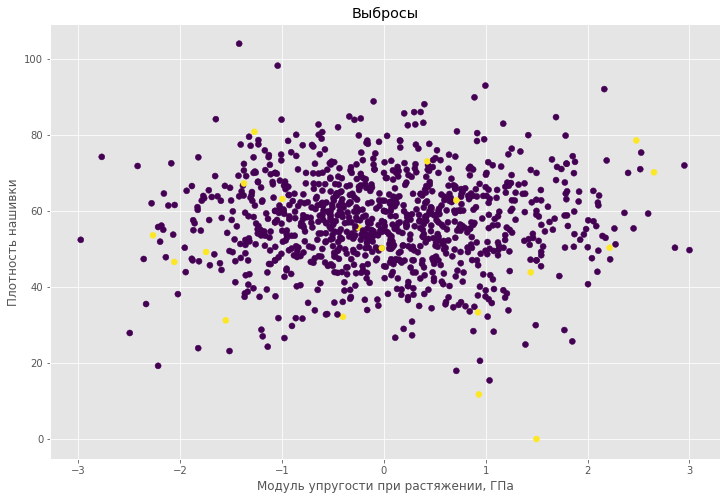

In [25]:
plot_scatter(cl_df['Модуль упругости при растяжении, ГПа'], df['Плотность нашивки'],'Выбросы','Модуль упругости при растяжении, ГПа','Плотность нашивки', c=cl_df["isf_outliers"] == -1)

In [26]:
print(cl_df[cl_df.isf_outliers == -1] ['isf_outliers'])

0      -1
19     -1
135    -1
148    -1
211    -1
279    -1
284    -1
332    -1
378    -1
460    -1
475    -1
478    -1
533    -1
589    -1
597    -1
677    -1
709    -1
741    -1
903    -1
938    -1
1008   -1
Name: isf_outliers, dtype: int32


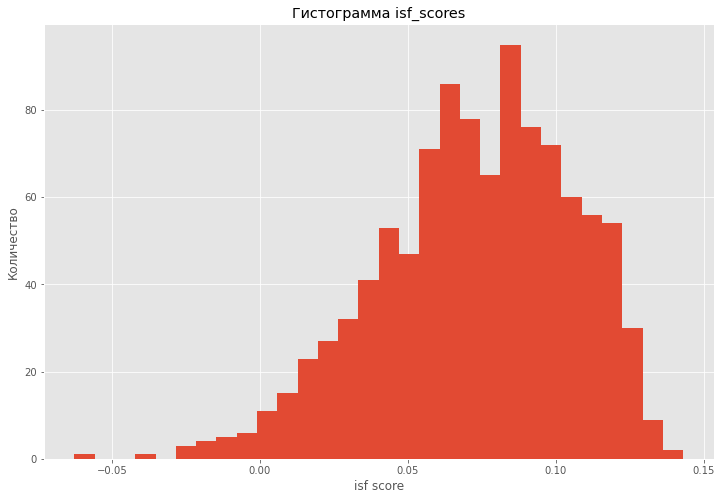

In [27]:
plot_hist(cl_df["isf_scores"], title="Гистограмма isf_scores", xlabel="isf score")

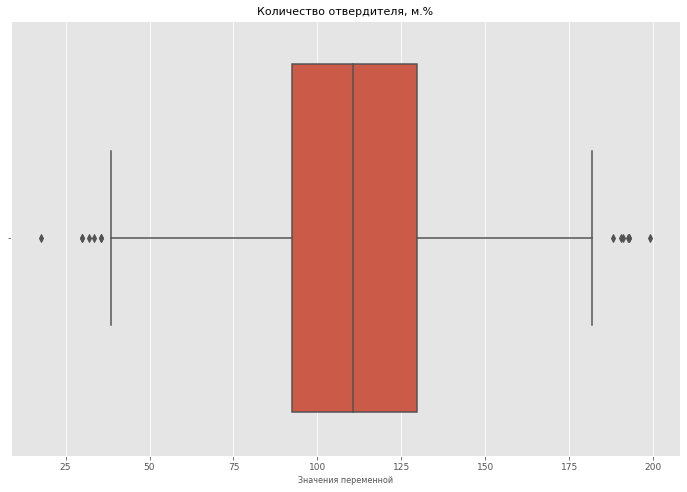

In [28]:
# не нравится количество отвердителя. посмотрм более пристально, но без эксперта нельзя сделать выводов - это выбросы или допустимые значения
ax = sns.boxplot(x=df['Количество отвердителя, м.%'])
ax.axes.set_title("Количество отвердителя, м.%",fontsize=11)
ax.set_xlabel("Значения переменной",fontsize=8)
ax.tick_params(labelsize=9)

In [29]:
# посмотрим выбросы, найденные в датасете после стандартизации
cl_df[cl_df.isf_outliers == -1]

Соотношение матрица-наполнитель  Плотность, кг/м3  \
0                           -1.175779          0.736365   
19                           0.659497          0.057877   
135                         -0.722339         -1.537494   
148                          0.369376          1.788689   
211                         -0.256561         -0.216509   
279                          1.647791          1.169496   
284                          2.733173          0.373674   
332                         -0.267062         -1.956422   
378                         -2.702771         -0.680175   
460                          0.181921          0.875182   
475                         -0.061135          0.080410   
478                         -0.302246          2.034802   
533                         -1.364149         -1.716790   
589                          2.591519          1.912159   
597                         -0.392876          1.229695   
677                         -1.442795          0.614425   
709                          2.207093          2.169356   
741                         -1.498563          0.600743   
903                          0.133646         -0.723104   
938                         -2.158337         -0.881565   
1008                        -0.800205          0.816784   

      модуль упругости, ГПа  Количество отвердителя, м.%  \
0                 -0.003594                    -2.848828   
19                 1.342372                     0.045585   
135                2.087275                     0.529886   
148               -0.084147                    -1.752930   
211               -2.160439                     0.758826   
279               -1.245331                    -1.043041   
284               -0.651719                     0.980159   
332               -2.119367                     0.718610   
378                0.766011                    -0.784512   
460               -0.615809                     2.049557   
475               -2.039857                     1.287072   
478                2.006560                     2.011778   
533                0.639583                    -2.205239   
589                0.284922                    -0.269638   
597               -0.886262                     2.113062   
677               -0.137827                     1.460773   
709                0.398530                    -0.762185   
741                2.755452                    -1.805895   
903               -1.828403                    -2.239726   
938               -1.999095                     1.417050   
1008               2.099043                    -1.098907   

      Содержание эпоксидных групп,%_2  Температура вспышки, С_2  \
0                            0.009757                 -4.542215   
19                           0.009757                 -0.030955   
135                          0.739768                  0.774363   
148                          2.107075                 -0.425116   
211                         -0.987721                  1.560092   
279                          0.402818                 -1.002072   
284                         -0.603181                  2.075628   
332                          1.383614                 -2.369399   
378                         -0.040231                 -3.069803   
460                         -1.175424                  1.066267   
475                          2.770368                 -0.653443   
478                          1.630755                 -0.765342   
533                         -0.360821                  1.176468   
589                         -1.090783                 -1.273900   
597                          1.788536                 -0.973877   
677                          2.650892                  0.451535   
709                          0.569192                 -2.143269   
741                         -2.272052                 -1.577336   
903                         -0.516592                  0.220515   
938                          1.901278         

***Для отправки вопросов эксперту необходимо выбросы исходного датасета. ***

In [30]:
from sklearn.ensemble import IsolationForest
isf = IsolationForest(n_estimators=100, random_state=42, contamination=0.02)
tmp_df = df.copy()
preds = isf.fit_predict(df[['Соотношение матрица-наполнитель',
                               'Плотность, кг/м3',
                               'модуль упругости, ГПа',
                               'Количество отвердителя, м.%',
                               'Содержание эпоксидных групп,%_2',
                               'Температура вспышки, С_2',
                               'Поверхностная плотность, г/м2',
                               'Модуль упругости при растяжении, ГПа',
                               'Прочность при растяжении, МПа',
                               'Потребление смолы, г/м2',
                               'Шаг нашивки',
                               'Плотность нашивки'
                              ]])
tmp_df["isf_outliers"] = preds
tmp_df["isf_scores"] = isf.decision_function(tmp_df[['Соотношение матрица-наполнитель',
                               'Плотность, кг/м3',
                               'модуль упругости, ГПа',
                               'Количество отвердителя, м.%',
                               'Содержание эпоксидных групп,%_2',
                               'Температура вспышки, С_2',
                               'Поверхностная плотность, г/м2',
                               'Модуль упругости при растяжении, ГПа',
                               'Прочность при растяжении, МПа',
                               'Потребление смолы, г/м2',
                               'Шаг нашивки',
                               'Плотность нашивки'
                              ]])
print(cl_df["isf_outliers"].value_counts())

 1    1002
-1      21
Name: isf_outliers, dtype: int64


***количество выбрросов нормализованного и исходного датасета одинаковое***

In [31]:
# посмотрим выбросы на исходных данных
tmp_df[tmp_df.isf_outliers == -1]

Соотношение матрица-наполнитель  Плотность, кг/м3  \
0                            1.857143       2030.000000   
19                           3.532338       1980.000000   
135                          2.271032       1862.432065   
148                          3.267523       2107.549113   
211                          2.696183       1959.779639   
279                          4.434429       2061.918771   
284                          5.425139       2003.272119   
332                          2.686598       1831.559944   
378                          0.463342       1925.610616   
460                          3.096419       2040.229870   
475                          2.874563       1981.660591   
478                          2.654483       2125.685960   
533                          1.685204       1849.219189   
589                          5.295842       2116.647950   
597                          2.571758       2066.355044   
677                          1.613418       2021.013801   
709                          4.944947       2135.601650   
741                          1.562514       2020.005530   
903                          3.052355       1922.447078   
938                          0.960288       1910.769529   
1008                         2.199958       2035.926322   

      модуль упругости, ГПа  Количество отвердителя, м.%  \
0                738.736842                    30.000000   
19              1183.000000                   111.860000   
135             1428.870308                   125.557042   
148              712.148822                    60.994261   
211               26.827000                   132.031952   
279              328.876626                    81.071393   
284              524.810110                   138.291706   
332               40.383455                   130.894546   
378              992.760436                    88.383137   
460              536.663039                   168.536509   
475               66.627290                   146.971837   
478             1402.228706                   167.468034   
533              951.030579                    48.202025   
589              833.967349                   102.944857   
597              447.394722                   170.332558   
677              694.430768                   151.884465   
709              871.465975                    89.014587   
741             1649.415706                    59.496316   
903              136.421878                    47.226653   
938               80.081588                   150.647888   
1008            1432.754588                    79.491398   

      Содержание эпоксидных групп,%_2  Температура вспышки, С_2  \
0                           22.267857                100.000000   
19                          22.267857                284.615385   
135                         24.023624                317.571591   
148                         27.312167                268.485007   
211                         19.868797                349.726171   
279                         23.213218                244.874100   
284                         20.793664                370.823575   
332                         25.572154                188.918674   
378                         22.147630                160.255843   
460                         19.417348                329.517248   
475                         28.907470                259.141151   
478                         26.166559                254.561855   
533                         21.376570                334.027049   
589                         19.620920                233.750031   
597                         26.546042                246.027954   
677                         28.620116                304.360421   
709                         23.613368                198.172641   
741                         16.779820                221.332443   
903                         21.001922                294.906351   
938                         26.817201         

***19 строка выглядит странно. Шаг и плотность нашивки = 0. Надо обратить внимание.***

In [32]:
# удалить выбросы не сложно. но надо ли....
tst_df = cl_df.copy()
tst_df.drop(tst_df[tst_df.isf_outliers == -1].index, inplace=True)
tst_df.shape

(1002, 15)

# Модели прогнозирования целевых переменных "Модуля  упругости при растяжении" и "прочности при растяжении"


In [33]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

## Датасеты для экспериментов

In [34]:
# df исходный датасет
# 
# src_df копия исходного датасета для экспериментов
src_df = df.copy()
# norm_df нормализованный датасет
norm_df = df.copy() 
min_max_scaler = MinMaxScaler().fit(norm_df)
norm_df = pd.DataFrame(min_max_scaler.transform(norm_df), columns=list(norm_df.columns))
# 
# std_df стандартизированный датафрейм
std_df = df.copy()
scaler = StandardScaler().fit(std_df)
std_df = pd.DataFrame(scaler.transform(std_df), columns=list(std_df.columns))
# 
isf = IsolationForest(n_estimators=100, random_state=42, contamination=0.02)
#
# cl_src_df копия исходного датасета для экспериментов без выбросов
cl_src_df = src_df.copy()
cl_src_df["isf_outliers"] = isf.fit_predict(cl_src_df)
cl_src_df.drop(cl_src_df[cl_src_df.isf_outliers == -1].index, inplace=True)
cl_src_df.drop(['isf_outliers'], axis=1, inplace = True)

# cl_norm_df нормализованный датасет без выбросов
cl_norm_df = norm_df.copy()
cl_norm_df["isf_outliers"] = isf.fit_predict(cl_norm_df)
cl_norm_df.drop(cl_norm_df[cl_norm_df.isf_outliers == -1].index, inplace=True)
cl_norm_df.drop(['isf_outliers'], axis=1, inplace = True)
# 
# cl_std_df стандартизированный датасет без выбросов
cl_std_df = std_df.copy()
cl_std_df["isf_outliers"] = isf.fit_predict(cl_std_df)
cl_std_df.drop(cl_std_df[cl_std_df.isf_outliers == -1].index, inplace=True)
cl_std_df.drop(['isf_outliers'], axis=1, inplace = True)

***в теории, модели должны лучше работать на датасете, в котором выбросы удалены. Сначала поработаем с ним, выберем лучшую модель и посмотрим ее результаты на датасете со всеми примерами***

In [35]:
# для сохранения резултатов
results = pd.DataFrame(columns=('model', 'score', 'MSE', 'R^2', 'Çomments'))

In [36]:
def add_result(rgr, X_train, y_train, comment = ''):
    model = str(rgr)
    score = rgr.score(X_train, y_train).round(5)
    MSE = mean_squared_error(y_test, y_pred).round(5)
    R2 = r2_score(y_test, y_pred).round(5)
    results.loc[len(results.index)] = [model, score, MSE, R2, comment]

In [37]:
# истина vs пророчества в цифрах
def view_preds(y_test, y_pred):
    view_preds = pd.DataFrame({'True': y_test, 'Predicted': y_pred})
    display (view_preds)

In [38]:
#  истина vs пророчества в картинках
def plot_preds(y_test, y_pred, title = ''):
    plt.plot(y_pred, 'r*')
    plt.plot(y_test.reset_index(drop=True),'g.')
    plt.legend(['Predictions', 'True data'])
    plt.title(title);
    plt.show()

# Регрессия

### LinearRegression

***модель на стандартизованном датасете дает худшие результаты, а разница между работой регрессора с полным нормализованным датасетом и нормализованным датасетом без выбросов не значительная***

#### 'Прочность при растяжении, МПа'

In [39]:
# делим датасет на обуающую и тестовую выборки
# в нормализованном датасете без выбросов результат кажется получше
# поэтому будем использовать его
# под вопросом 30% на тестовую выборку, слишком роскошно для датасета в 1000 записей, но ТЗ есть ТЗ
X = cl_norm_df.copy()
y = X.pop('Прочность при растяжении, МПа')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=330)

In [40]:
rgr = LinearRegression()
rgr.fit(X_train, y_train)
y_pred = rgr.predict(X_test)
add_result(rgr, X_train, y_train, 'Прочность при растяжении, МПа')

In [41]:
view_preds(y_test, y_pred)

True  Predicted
134  0.510199   0.518438
893  0.509192   0.507003
996  0.484589   0.500569
684  0.744591   0.529536
565  0.297300   0.493706
..        ...        ...
743  0.411923   0.520601
801  0.569279   0.511554
425  0.426811   0.498576
476  0.552934   0.504626
16   0.698235   0.486309

[301 rows x 2 columns]

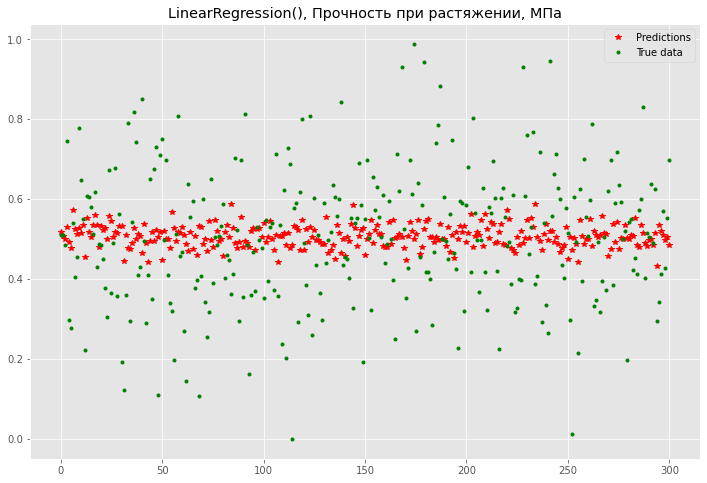

In [42]:
plot_preds(y_test, y_pred, str(rgr) + ', Прочность при растяжении, МПа')

***Модель линейного регрессора не справляется с задачей. Применять линейный регрессор для получения предсказания переменной "Модуль упругости при растяжении, ГПа" смысла не имеет, так как корреляция данных в датасете не наблюдается***

### KNeighborsRegressor

In [43]:
rgr = KNeighborsRegressor(n_neighbors=7)
rgr.fit(X_train, y_train)
y_pred = rgr.predict(X_test)
add_result(rgr, X_train, y_train, 'Прочность при растяжении, МПа')

In [44]:
# пробуем улучшить knr автоматическим подбором гиперпараметров
# гиперпараметры knr
hyps = [{'n_neighbors': range(1, 101, 2)
         ,'weights': ['uniform','distance'],
       }]

# подбор параметров
grid = GridSearchCV(estimator=KNeighborsRegressor(), 
                      param_grid=hyps, 
                      n_jobs=-1)

grid.fit(X_train,y_train)

# print(grid.best_params_)
# print(grid.best_estimator_)

rgr = grid.best_estimator_
y_pred = rgr.predict(X_test)

# rgr.get_params()
add_result(rgr, X_train, y_train, 'Прочность при растяжении, МПа')

### RandomForestRegressor

In [45]:
# заметен долгий поиск по сетке для леса при. попробовать RandomizedSearchCV
rgr = RandomForestRegressor(random_state=330)
hyps = {
        'n_estimators' : range(100, 1000, 100),
        'max_depth' : range(10, 25, 5)
        }

grid = GridSearchCV(rgr, hyps, n_jobs = -1)
grid.fit(X_train,y_train)
rgr = grid.best_estimator_
y_pred = rgr.predict(X_test)
add_result(rgr, X_train, y_train, 'Прочность при растяжении, МПа')

In [46]:
rgr.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 900,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 330,
 'verbose': 0,
 'warm_start': False}

In [47]:
# смотри RandomizedSearchCV
rgr = RandomForestRegressor(random_state=330)
hyps = {
        'n_estimators' : range(100, 1000, 100),
        'max_depth' : range(10, 25, 5)
        }

grid = RandomizedSearchCV(rgr,hyps,n_jobs = -1)
grid.fit(X_train,y_train)
rgr = grid.best_estimator_
y_pred = rgr.predict(X_test)
add_result(rgr, X_train, y_train, 'Прочность при растяжении, МПа')

In [48]:
rgr.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 330,
 'verbose': 0,
 'warm_start': False}

### GradientBoostingRegressor

In [49]:
rgr = GradientBoostingRegressor(random_state=330)
hyps = {
        'n_estimators' : range(80, 100, 5),
        'max_depth' : range(5, 10, 1)
        }

grid = GridSearchCV(rgr,hyps,n_jobs=-1)
grid.fit(X_train,y_train)
rgr = grid.best_estimator_
y_pred = rgr.predict(X_test)
add_result(rgr, X_train, y_train, 'Прочность при растяжении, МПа')

### Ridge 
https://machinelearningmastery.com/how-to-tune-algorithm-parameters-with-scikit-learn/
https://stackoverflow.com/questions/57376860/how-to-run-gridsearchcv-with-ridge-regression-in-sklearn
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

In [50]:
rgr = Ridge(random_state=330)
alphas = np.arange(290, 300, 0.01)
hyps = dict(alpha=alphas)
grid = GridSearchCV(rgr, hyps)
grid.fit(X_train, y_train)
rgr = grid.best_estimator_
y_pred = rgr.predict(X_test)
add_result(rgr, X_train, y_train, 'Прочность при растяжении, МПа')

### Lasso
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html


In [51]:
rgr = Lasso(random_state=330)
alphas = np.arange(0.001, 0.002, 0.0001)
hyps = dict(alpha=alphas)
grid = GridSearchCV(rgr, hyps)
grid.fit(X_train, y_train)
rgr = grid.best_estimator_
y_pred = rgr.predict(X_test)
add_result(rgr, X_train, y_train, 'Прочность при растяжении, МПа')

In [52]:
results.sort_values(by=['R^2'], ascending=False, inplace=True)
results

model    score      MSE  \
6   Ridge(alpha=299.9899999999909, random_state=330)  0.00254  0.02848   
7  Lasso(alpha=0.0019000000000000004, random_stat...  0.00048  0.02851   
2                KNeighborsRegressor(n_neighbors=85)  0.01680  0.02876   
0                                 LinearRegression()  0.02285  0.02877   
3  RandomForestRegressor(max_depth=10, n_estimato...  0.65990  0.02904   
4  RandomForestRegressor(max_depth=10, n_estimato...  0.65962  0.02905   
5  GradientBoostingRegressor(max_depth=5, n_estim...  0.73587  0.03228   
1                 KNeighborsRegressor(n_neighbors=7)  0.12837  0.03265   

       R^2                       Çomments  
6  0.00094  Прочность при растяжении, МПа  
7 -0.00030  Прочность при растяжении, МПа  
2 -0.00915  Прочность при растяжении, МПа  
0 -0.00929  Прочность при растяжении, МПа  
3 -0.01877  Прочность при растяжении, МПа  
4 -0.01907  Прочность при растяжении, МПа  
5 -0.13260  Прочность при растяжении, МПа  
1 -0.14557  Прочность при растяжении, МПа

In [53]:
results.to_excel('results.xlsx')

#### 'Модуль упругости при растяжении, ГПа'

In [54]:
# для сохранения резултатов
results = pd.DataFrame(columns=('model', 'score', 'MSE', 'R^2', 'Çomments'))

In [55]:
X = cl_norm_df.copy()
y = X.pop('Модуль упругости при растяжении, ГПа')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=330)

In [56]:
hyps = [{'n_neighbors': range(80, 110, 5)}]


grid = GridSearchCV(estimator=KNeighborsRegressor(), 
                      param_grid=hyps, 
                      n_jobs=-1)
grid.fit(X_train,y_train)
rgr = grid.best_estimator_
y_pred = rgr.predict(X_test)
add_result(rgr, X_train, y_train, 'Модуль упругости при растяжении, ГПа')

In [57]:
rgr = Ridge(random_state=330)
alphas = np.arange(10, 15, 1)
hyps = dict(alpha=alphas)
grid = GridSearchCV(rgr, hyps)
grid.fit(X_train, y_train)
rgr = grid.best_estimator_
y_pred = rgr.predict(X_test)
add_result(rgr, X_train, y_train, 'Модуль упругости при растяжении, ГПа')

In [58]:
rgr = GradientBoostingRegressor(random_state=330)
hyps = {
        'n_estimators' : range(80, 100, 5),
        'max_depth' : range(5, 10, 1)
        }

grid = GridSearchCV(rgr,hyps,n_jobs=-1)
grid.fit(X_train,y_train)
rgr = grid.best_estimator_
y_pred = rgr.predict(X_test)
add_result(rgr, X_train, y_train, 'Прочность при растяжении, МПа')

In [59]:
results.sort_values(by=['R^2'], ascending=False, inplace=True)
results

model    score      MSE  \
0                KNeighborsRegressor(n_neighbors=80)  0.03839  0.02907   
1                  Ridge(alpha=12, random_state=330)  0.02108  0.02950   
2  GradientBoostingRegressor(max_depth=5, n_estim...  0.74131  0.03330   

       R^2                              Çomments  
0 -0.01134  Модуль упругости при растяжении, ГПа  
1 -0.02641  Модуль упругости при растяжении, ГПа  
2 -0.15867         Прочность при растяжении, МПа

In [60]:
results.to_excel('results2.xlsx')

***Линейные регрессоры не справляются с задачей прогнозированя целевых переменных по имеющимся признакам. Возможно трансформация входов и/или выходов поможет улучшить результаты модели, но для выбора вариантов трансформации необходима консультация с экспертом в предметной области. В принципе, признак 'Плотность, кг/м3' должен хоть как-то коррелировать с переменной 'Потребление смолы, г/м2', но зависимости не наблюдается.***